<a href="https://colab.research.google.com/github/y3y-tech/CX4240_Project/blob/main/Preliminary_Stock_Predictor_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN, Input, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D


## Data - Feature Engineering

In [ ]:

# Feature Engineering
"""
Arguments:
    ticker: str: the stock ticker
    start: str: the start date
    end: str: the end date
    seq_len: int: the sequence length
Returns:
    X_scaled: np.array: the scaled features
    X_seq: np.array: the sequence features
    y_seq: np.array: the target
"""

def load_and_engineer_data(ticker="^GSPC", start="2020-01-01", end="2024-01-01", seq_len=10):
    # Download the data from the Yahoo Finance API
    df = yf.download(ticker, start=start, end=end)

    # Manipulation
    df['Return'] = df['Close'].pct_change()
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA10'] = df['Close'].rolling(window=10).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['Volatility'] = df['Return'].rolling(window=10).std()
    df['Momentum'] = df['Close'] - df['Close'].shift(5)
    df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
    df.dropna(inplace=True)

    # Save the df as a table in the data folder
    df.to_csv(f'Data/{ticker}.csv')

    features = ['MA5', 'MA10', 'MA20', 'Volatility', 'Momentum', 'Return']
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[features])
    y = df['Target'].values

    # Sequence data for DL
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X_scaled)):
        X_seq.append(X_scaled[i-seq_len:i])
        y_seq.append(y[i])

    # Print header of the array 
    print(X_seq, y_seq)
    return np.array(X_scaled[seq_len:]), np.array(X_seq), np.array(y_seq)

load_and_engineer_data()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

[array([[-1.35652652, -1.30816143, -1.33913923, -0.46719535, -0.47031752,
         0.18125957],
       [-1.3835394 , -1.32586263, -1.34229774, -0.33971809, -0.73740704,
        -1.24651476],
       [-1.38149652, -1.34151046, -1.34092318, -0.30122582, -0.02148476,
         0.46354094],
       [-1.37325166, -1.34600895, -1.33591042, -0.12980598,  0.13132964,
         0.99284058],
       [-1.34958302, -1.34349989, -1.32638412, -0.0564987 ,  0.51136549,
         0.73730829],
       [-1.32559382, -1.33957534, -1.31732482, -0.05245072,  0.51926383,
         0.19436662],
       [-1.28613069, -1.33332398, -1.31214598, -0.08527829,  0.90053554,
        -0.40349343],
       [-1.24628902, -1.31229346, -1.30367187, -0.26477921,  0.90986256,
         0.4684589 ],
       [-1.2230568 , -1.29648861, -1.29687029, -0.29794627,  0.50061212,
         0.08220095],
       [-1.20577164, -1.27592543, -1.28746221, -0.298619  ,  0.35407923,
         0.40928273]]), array([[-1.3835394 , -1.32586263, -1.34229774, 

(array([[-1.194897  , -1.25842006, -1.27919229, -0.28414694,  0.19612627,
         -0.14518031],
        [-1.17464217, -1.22843527, -1.2730033 , -0.65703035,  0.42725043,
          0.09282427],
        [-1.16761382, -1.20490151, -1.26903003, -0.61519451,  0.10135542,
         -0.23352459],
        ...,
        [ 1.49485374,  1.48864558,  1.36209233, -0.49082089,  0.05387475,
          0.06452419],
        [ 1.52767856,  1.5034325 ,  1.38483292, -0.60321975,  0.7369701 ,
         -0.0081165 ],
        [ 1.5365915 ,  1.51318188,  1.40457038, -0.58811865,  0.14779072,
         -0.22712106]]),
 array([[[-1.35652652, -1.30816143, -1.33913923, -0.46719535,
          -0.47031752,  0.18125957],
         [-1.3835394 , -1.32586263, -1.34229774, -0.33971809,
          -0.73740704, -1.24651476],
         [-1.38149652, -1.34151046, -1.34092318, -0.30122582,
          -0.02148476,  0.46354094],
         ...,
         [-1.24628902, -1.31229346, -1.30367187, -0.26477921,
           0.90986256,  0.4684

## Model training 

[*********************100%***********************]  1 of 1 completed
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:08:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


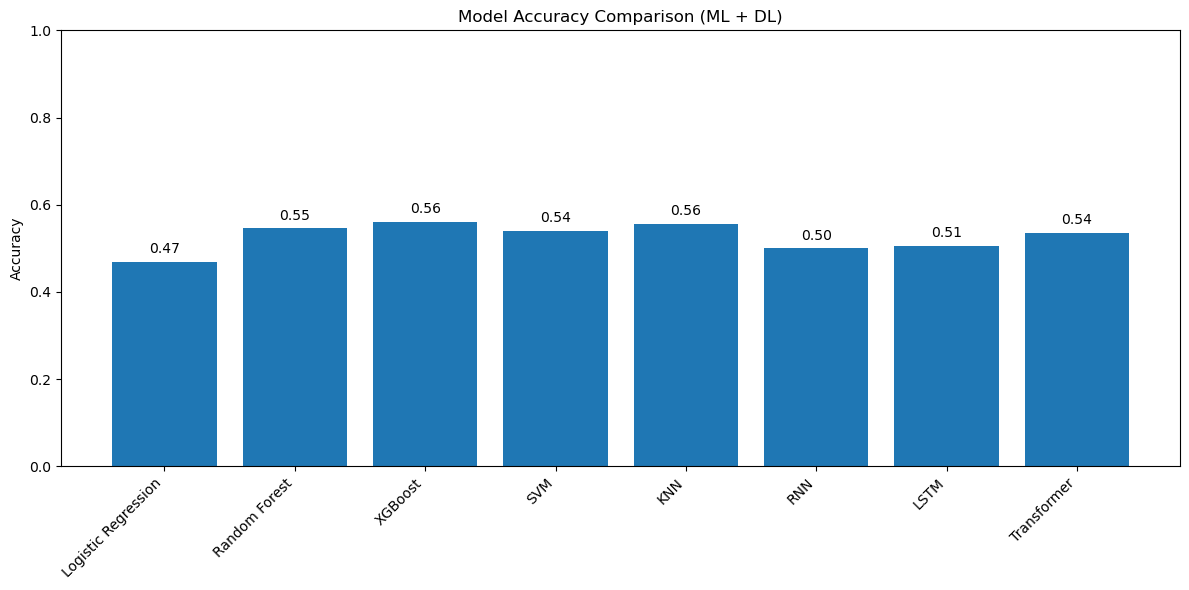

In [5]:
# Machine Learning Models
def train_ml_models(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    models = {"Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "SVM": SVC(),
        "KNN": KNeighborsClassifier(n_neighbors=5)
    }
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        acc = model.score(X_test, y_test)
        results[name] = round(acc, 4)
    return results

# Deep Learning Models
def train_rnn(X_seq, y_seq):
    X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)
    model = Sequential([SimpleRNN(64, input_shape=(X_seq.shape[1], X_seq.shape[2])),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=0)
    _, acc = model.evaluate(X_test, y_test, verbose=0)
    return round(acc, 4)

def train_lstm(X_seq, y_seq):
    X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)
    model = Sequential([LSTM(64, input_shape=(X_seq.shape[1], X_seq.shape[2])),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=0)
    _, acc = model.evaluate(X_test, y_test, verbose=0)
    return round(acc, 4)

def transformer_encoder(inputs, head_size=64, num_heads=2, ff_dim=128, dropout=0.1):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

def train_transformer(X_seq, y_seq):
    X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)
    input_layer = Input(shape=(X_seq.shape[1], X_seq.shape[2]))
    x = transformer_encoder(input_layer)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=0)
    _, acc = model.evaluate(X_test, y_test, verbose=0)
    return round(acc, 4)

# Run & Compare All Models
X_flat, X_seq, y_seq = load_and_engineer_data()
ml_results = train_ml_models(X_flat, y_seq)
dl_results = {
    "RNN": train_rnn(X_seq, y_seq),
    "LSTM": train_lstm(X_seq, y_seq),
    "Transformer": train_transformer(X_seq, y_seq)
}

# Combine & Plot
all_results = {**ml_results, **dl_results}
plt.figure(figsize=(12, 6))
bars = plt.bar(all_results.keys(), all_results.values())
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison (ML + DL)")
plt.xticks(rotation=45, ha='right')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02, f"{height:.2f}", ha='center')
plt.tight_layout()
plt.show()
